## CNN with MNIST test dataset

In [1]:
import tensorflow as tf
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


tf.__version__

'2.4.0'

## MNIST data process

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# Data is 0~255 so we must normalize our data first
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
y_train[0:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [5]:
print("categorical labels")
print(y_train[0:5])

# make labels one hot encoded
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

print("one hot encoded labels")
print(y_train[0:5])

categorical labels
[5 0 4 1 9]
one hot encoded labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(5, 10), dtype=float32)


In [6]:
x_test.shape[0]

10000

In [7]:
x_train.shape[0]

60000

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(50)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(50)

In [9]:
from tensorflow.keras.layers import Flatten
flatten = Flatten(dtype='float32')

print(x_train.shape)
print(flatten(x_train).shape)

(60000, 28, 28)
(60000, 784)


In [10]:
W = tf.Variable(tf.zeros([784, 10], tf.float32))
b = tf.Variable(tf.zeros([10], tf.float32))

In [11]:
def forward(x):
    return tf.matmul(x, W) + b

In [12]:
# a sample softmax calculation on an input vector
vector = [10, 0.2, 8]
softmax = tf.nn.softmax(vector)
print("softmax calculation")
print(softmax.numpy())
print("verifying normalization")
print(tf.reduce_sum(softmax))
print("finding vector with largest value (label assignment)")
print("category", tf.argmax(softmax).numpy())

softmax calculation
[8.8075405e-01 4.8839214e-05 1.1919709e-01]
verifying normalization
tf.Tensor(0.99999994, shape=(), dtype=float32)
finding vector with largest value (label assignment)
category 0


In [13]:
def activate(x):
    return tf.nn.softmax(forward(x))

In [14]:
def model(x):
    x = flatten(x)
    return activate(x)

In [15]:
def cross_entropy(y_label, y_pred):
    return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))
# addition of 1e-10 to prevent errors in zero calculations


# current loss function for unoptimized model
cross_entropy(y_train, model(x_train)).numpy()

138155.11

## 1. Gradient Descent

In [16]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.25)

In [17]:
def train_step(x, y):
    with tf.GradientTape() as tape:
        current_loss = cross_entropy(y, model(x))

        grads = tape.gradient(current_loss, [W, b])
        optimizer.apply_gradients(zip(grads, [W, b]))
    return current_loss.numpy()

## Training by Graident Descent

In [21]:
# zeroing out weights in case you want to run this cell multiple times
# Weight tensor
W = tf.Variable(tf.zeros([784, 10],tf.float32))
# Bias tensor
b = tf.Variable(tf.zeros([10],tf.float32))

loss_values=[]
accuracies = []
epochs = 10

for i in range(epochs):
    j=0
    # each batch has 50 examples
    for x_train_batch, y_train_batch in train_ds:
        j+=1
        current_loss = train_step(x_train_batch, y_train_batch)
        if j%500==0: #reporting intermittent batch statistics
            print("epoch ", str(i+1), "batch", str(j), "loss:", str(current_loss) ) 
    
    # collecting statistics at each epoch...loss function and accuracy
    #  loss function
    current_loss = cross_entropy( y_train, model( x_train )).numpy()
    loss_values.append(current_loss)
    correct_prediction = tf.equal(tf.argmax(model(x_train), axis=1),
                                  tf.argmax(y_train, axis=1))
    #  accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    accuracies.append(accuracy)
    print("end of epoch ", str(i+1), "loss", str(current_loss), "accuracy", str(accuracy) ) 

epoch  1 batch 500 loss: 182.31589
epoch  1 batch 1000 loss: 237.19542
end of epoch  1 loss 217306.38 accuracy 0.8201333
epoch  2 batch 500 loss: 206.9339
epoch  2 batch 1000 loss: 219.18332
end of epoch  2 loss 231224.31 accuracy 0.8100833
epoch  3 batch 500 loss: 210.7546
epoch  3 batch 1000 loss: 248.913
end of epoch  3 loss 208950.2 accuracy 0.83105
epoch  4 batch 500 loss: 165.24435
epoch  4 batch 1000 loss: 207.55893
end of epoch  4 loss 207672.92 accuracy 0.8330167
epoch  5 batch 500 loss: 184.96556
epoch  5 batch 1000 loss: 195.71907
end of epoch  5 loss 204012.67 accuracy 0.83708334
epoch  6 batch 500 loss: 155.63136
epoch  6 batch 1000 loss: 174.49988
end of epoch  6 loss 206519.06 accuracy 0.8361167
epoch  7 batch 500 loss: 189.26016
epoch  7 batch 1000 loss: 174.0267
end of epoch  7 loss 207498.34 accuracy 0.8331
epoch  8 batch 500 loss: 203.73929
epoch  8 batch 1000 loss: 213.21356
end of epoch  8 loss 205742.67 accuracy 0.83666664
epoch  9 batch 500 loss: 186.01166
epoch 

In [22]:
correct_prediction_train = tf.equal(tf.argmax(model(x_train), axis=1),tf.argmax(y_train,axis=1))
accuracy_train = tf.reduce_mean(tf.cast(correct_prediction_train, tf.float32)).numpy()

correct_prediction_test = tf.equal(tf.argmax(model(x_test), axis=1),tf.argmax(y_test, axis=1))
accuracy_test = tf.reduce_mean(tf.cast(correct_prediction_test, tf.float32)).numpy()
print("training accuracy", accuracy_train)
print("test accuracy", accuracy_test)

training accuracy 0.8395333
test accuracy 0.8348


Text(0, 0.5, 'loss')

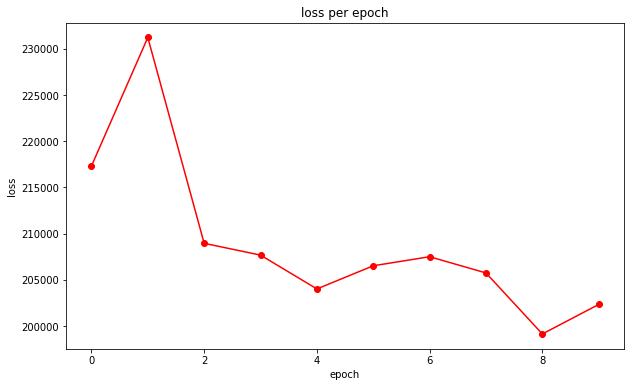

In [29]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,6)
plt.plot(loss_values,'-ro')
plt.title("loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0, 0.5, 'accuracy')

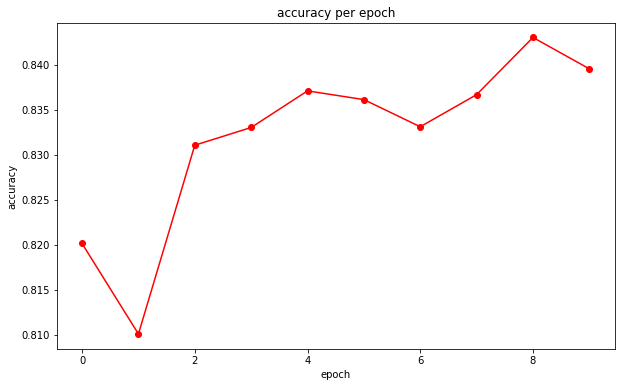

In [30]:
plt.plot(accuracies,'-ro')
plt.title("accuracy per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")

## Conclusion

### Gradient Descent is not enough for MNIST image recognition

<h4>Several options as follow:</h4>
<ul>
    <li>Regularization of Neural Networks using DropConnect</li>
    <li>Multi-column Deep Neural Networks for Image Classification</li> 
    <li>APAC: Augmented Pattern Classification with Neural Networks</li>
    <li>Simple Deep Neural Network with Dropout</li>
</ul>
<h4>In the next part we are going to explore the option:</h4>
<ul>
    <li>Simple Deep Neural Network with Dropout (more than 1 hidden layer)</li>
</ul> 